### Charlie BROSSE, Adrien HUET

### Nouvelle Baguette Magique

In [1]:
! pip install pyspark

# Statistics and Analysis

In [2]:
import os
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

Spark setup

In [3]:
spark = (SparkSession.builder.appName('nouvelle_baguette_magique').getOrCreate())
spark.sparkContext.setLogLevel('ERROR')

22/06/21 22:10:27 WARN Utils: Your hostname, forss resolves to a loopback address: 127.0.1.1; using 172.18.66.219 instead (on interface eth0)
22/06/21 22:10:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/21 22:10:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/06/21 22:10:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


*Load* the differents csv: we store them in a dictionary where keys are the companies names

In [4]:
csv_dict = {}

In [5]:
for file in os.listdir('stocks_data'):
  if not file.endswith('.csv'):
    continue
  name = file[:file.rfind('.csv')]
  print(name)
  df = spark.read.csv('stocks_data/' + file, header=True)
  csv_dict[name] = df

AMAZON
APPLE
FACEBOOK
GOOGLE
MICROSOFT
TESLA
ZOOM


In [6]:
companies = csv_dict.keys()
print(companies)

dict_keys(['AMAZON', 'APPLE', 'FACEBOOK', 'GOOGLE', 'MICROSOFT', 'TESLA', 'ZOOM'])


Show the first and last 40 rows of each stock price:

In [7]:
def first_and_last_40(df: DataFrame):
  """
  Prints the first 40 and the last 40 rows of the stock data of the given DataFrame
  """
  print('HEAD:')
  print(df.head(40))
  print('TAIL:')
  print(df.tail(40))
  print()

Get the number of observations:

In [8]:
def get_nb_obs():
  """
  Return the total number of observations in the dataframes of csv_dict (csv_dict must be defined earlier)
  """
  count = 0
  for company in companies:
    count += csv_dict[company].count()
  return count

Deduce programmatically what is the period you have between the data points : for
example, if you have data point with the following date [01/01, 02/01, …..], you
shoud have a function that will analyse the difference between the dates
automatically and deduce it is a day period

In [9]:
def seconds_to_period(seconds: float):
  """
  Get the order of time (hours, days, weeks, months, years) of the given number of seconds.
  For example, seconds_to_period(3600) = 'hours'
  """
  conversions = {'minutes': 60,
                'hours': 3600,
                'days': 3600*24,
                'weeks': 3600*24*7,
                'months': 3600*24*7*3,
                'year': 3600*24*7*52}

  prev = 'seconds'
  for order in conversions:
      if seconds / conversions[order] < 1:
        return prev
      prev = order
  return 'year'
        
def get_order(df: DataFrame):
  """
  Return the the sample period (str) of the given dataframe
  """
  # Only get the dates
  dates = df.select(to_date(df.Date).alias('ts'))

  # Duplicating the ts column with a shift of 1, so that each row contains the current timestamp and the previous one
  my_window = Window.partitionBy().orderBy("ts")
  dates = dates.withColumn("prev_ts", lag(dates.ts).over(my_window))

  # Get the difference in seconds between ts and the newly created 'prev_ts' column
  dates = dates.withColumn("diff", unix_timestamp(dates.ts) - unix_timestamp(dates.prev_ts))
  # Get the average of the diff
  diff_avg = dates.agg({'diff': 'mean'}).collect()[0][0]

  # The diff is the average step between two timestamp, this finds its order of time (seconds, minutes, hours, ...)
  order = seconds_to_period(diff_avg)
  return order

Descriptive statistics for each dataframe and each column (min, max, standard
deviation)


In [10]:
def show_descriptive_stats(df: DataFrame):
  """
  Prints on the output descriptive statistics for the given DataFrame
  """
  df.summary().show()

Number of missing values for each dataframe and column


In [11]:
def show_missing_values(df: DataFrame):
  """
  Returns a DataFrame containing the number of NaNs and null values for each column in the given DataFrame
  """
  return df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

	There are no missing values nor null values except in company name.

Correlation between values 

Voici les matrices de corrélations entre chaque colonnes pour chaque entreprises

In [12]:
def show_correlation_matrix(df: DataFrame):
  """
  Returns the correlation matrix over the columns of the given DataFrame
  """
  corr_mat = np.empty(6, dtype=object)
  corr_mat[...] = [[] for _ in range(corr_mat.shape[0])]
  copy = df.alias("copy")
  cols = copy.columns[1:-1]

  for c in cols:
    copy = copy.withColumn(c, copy[c].cast(IntegerType()))

  for i, col1 in enumerate(cols):
    for j, col2 in enumerate(cols):
      corr_mat[i].append(copy.stat.corr(col1, col2))
  
  return corr_mat

What is the average of the opening and closing prices for each stock price and for
different time periods (week, month, year)

In [13]:
from pyspark.sql.functions import *

def show_average_open_close_stock_per_timeperiod(df: DataFrame):
  """
  Returns a tuple of DataFrames containing the weekly, monthly and yearly average of the stock prices for open and close in the given DataFrame
  """
  # week
  weekly_open_close = df.withColumn("week_strt_day",date_sub(next_day(col("Date"),"sunday"),7)).groupBy("week_strt_day").agg(mean("Open").cast("int").alias("Open"),mean("Close").cast("int").alias("Close")).orderBy("week_strt_day")

  # month
  monthly_open_close = df.withColumn("month_strt_day",substring('Date', 0, 7)).groupBy("month_strt_day").agg(mean("Open").cast("int").alias("Open"),mean("Close").cast("int").alias("Close")).orderBy("month_strt_day")
  
  # year
  yearly_open_close = df.withColumn("year_strt_day",substring('Date', 0, 4)).groupBy("year_strt_day").agg(mean("Open").cast("int").alias("Open"),mean("Close").cast("int").alias("Close")).orderBy("year_strt_day")

  return [weekly_open_close, monthly_open_close, yearly_open_close]

How do the stock prices change day to day and month to month (may be you can
create new columns to save those calculations)


In [14]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

def show_stock_price_evolution_per_timeperiod(df: DataFrame):
  """
  Return a couple of DataFrames containing the stock price evolution per timeperiod.
  """
  # day by day evolution for Close
  w1 = Window().partitionBy().orderBy(col("Date"))
  df_with_day_evol = df.select("*", lag("Close").over(w1).alias("tmp")).na.drop()
  df_with_day_evol = df_with_day_evol.withColumn("day_evolution", df_with_day_evol["Close"] - df_with_day_evol["tmp"])
  df_with_day_evol = df_with_day_evol.drop(df_with_day_evol["tmp"])
  

  # month by month evolution for Close
  w2 = Window().partitionBy().orderBy(col("month_strt_day"))

  df_with_monthly_evol = df.withColumn("month_strt_day",substring('Date', 0, 7)).groupBy("month_strt_day").agg(mean("Close").cast("int").alias("Close")).orderBy("month_strt_day")
  df_with_monthly_evol = df_with_monthly_evol.select("*", lag("Close").over(w2).alias("tmp")).na.drop()
  df_with_monthly_evol = df_with_monthly_evol.withColumn("month_evolution", df_with_monthly_evol["Close"] - df_with_monthly_evol["tmp"])
  df_with_monthly_evol = df_with_monthly_evol.drop(df_with_monthly_evol["tmp"])

  return (df_with_day_evol, df_with_monthly_evol)

Based on the opening and closing price, calculate the daily return of each stock

In [15]:
def show_daily_return(df: DataFrame):
  """
  Return an updated version of the given DataFrame with an additional column containing the daily evolution of the stock price
  """
  df_with_daily_return = df.withColumn("daily_return", df["Close"] - df["Open"])
  return df_with_daily_return

What are the stocks with the highest daily return

In [16]:
def show_max_daily_return(df: DataFrame):
  """
  Return the maximum values of daily_return from the given DataFrame
  """
  return df.groupby().max("daily_return").first().asDict()['max(daily_return)']

Calculate the average daily return for different periods (week, month, and year)

In [17]:
def show_average_daily_return_per_timeperiod(df):
  """
  Returns a tuple of DataFrames containing the weekly, monthly and yearly average of the stock price daily evolution computed from the given DataFrame
  """
  # week
  weekly = df.withColumn("week_strt_day",date_sub(next_day(col("Date"),"sunday"),7)).groupBy("week_strt_day").agg(mean("daily_return").cast("int").alias("average_daily_return")).orderBy("week_strt_day")

  # month
  monthly = df.withColumn("month_strt_day",substring('Date', 0, 7)).groupBy("month_strt_day").agg(mean("daily_return").cast("int").alias("average_daily_return")).orderBy("month_strt_day")
  
  # year
  yearly = df.withColumn("year_strt_day",substring('Date', 0, 4)).groupBy("year_strt_day").agg(mean("daily_return").cast("int").alias("average_daily_return")).orderBy("year_strt_day")

  return [weekly, monthly, yearly]
  

**Moving average** : The moving average is calculated by adding a stock's prices over a certain
period and dividing the sum by the total number of periods. For example, if you want to
calculate the moving average for the opening price of the stock ABC. You look at the opening
price over five periods and calculate the average. For example if the opening price over the
past five days were 25.40, 25.90. 26.50, 26.30 and 27.90. Then, the moving average of the
opening price of the last day is 26.40. **Code a function** that take as input a dataframe, a
column name, the number of points to consider for the moving average (5 in the example)
and add a new column to the dataframe with the values of calculated moving average

In [18]:
def moving_average(df: DataFrame, column: str, nb_periods: int):
  """
  Returns a updated version of the given DataFrame containing the rolling average of the specified column over the given number of periods
  The new column is given the name 'roll_[column]_[nb_periods]'
  """
  conversions = {'minutes': 60,
                'hours': 3600,
                'days': 3600*24,
                'weeks': 3600*24*7,
                'months': 3600*24*7*3,
                'year': 3600*24*7*52}
  order = get_order(df)

  df = df.withColumn('timestampGMT', df.Date.cast('timestamp'))

  # create window by casting timestamp to long (number of seconds)
  w = (Window.orderBy(col("timestampGMT").cast('long')).rangeBetween(-(nb_periods * conversions[order]), 0))

  df = df.withColumn('roll_' + column + '_' + str(nb_periods), avg(column).over(w))
  return df.drop('timestampGMT')

**Correlation** : Is there any correlation between the different stocks you have ? **Code a
function** that takes as input the values of two stocks (you should decide what is the data
type that will handle the values) and calculate the correlation between them


In [19]:
def corr_between(df1: DataFrame, df2: DataFrame, column: str):
  """
  Returns the correlation coeficient between the two given DataFrames over the given column
  """
  df = df1.select(col(column).cast('float')).withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
  df_other = df2.select(col(column).cast('float')).withColumnRenamed(column, column + '_other').withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
  joined = df.join(df_other, on=['row_index']).drop('row_index')
  return joined.stat.corr(column, column + '_other')

When investing in stocks, the return rate is very important. **Code a function** that calculates
the return rate of the stock in different periods (week, month and year) 

In [20]:
def compute_return_rate(df: DataFrame, period: str = 'year'):
  """
  Returns a DataFrame containing the returns rate with dates spanning in the fashion of the given period (defaults to 'year')
  """
  # Extract year, month and week from df
  split = df.withColumn(
      'year', year(df.Date)).withColumn(
      'month', month(df.Date)).withColumn(
      'week', weekofyear(df.Date))

  date_window = Window.partitionBy().orderBy('Date')
  with_prev = split.withColumn('prev_value', lag(split['Adj Close']).over(date_window))
  with_diff = with_prev.withColumn('diff', with_prev['Adj Close'] - with_prev['prev_value'])
  pct_change = with_diff.withColumn('pct_change', with_diff['diff'] / with_diff['prev_value'] * 100)

  if period == 'year':
    return pct_change.groupBy('year').agg(sum('pct_change').alias('return_rate'))
  elif period == 'month':
    return pct_change.groupBy('year', 'month').agg(sum('pct_change').alias('return_rate'))
  elif period == 'week':
    return pct_change.groupBy('year', 'week').agg(sum('pct_change').alias('return_rate'))
  elif period == 'day':
    return pct_change.drop('prev_value', 'diff', 'year', 'month', 'week').withColumnRenamed('pct_change', 'return_rate')
  else:
    raise ValueError(f'{period} is not a valid period. Should be either "year", "month", "week" or "day"')

Given a specific month, what is the stock with the best return rate. **Code a function** that
takes as input a start date and a period (month, year), calculate the return rate for each
stock and return the one with the best return rate.

In [21]:
def return_rate_over_period(df: DataFrame, start_date: datetime, end_date: datetime):
  """
  Compute and returns the return rate between two dates for the given DataFrame
  """
  ranged = df.filter(df.Date >= start_date).filter(df.Date <= end_date)
  
  date_window = Window.partitionBy().orderBy('Date')
  with_prev = ranged.withColumn('prev_value', Functions.lag(ranged['Adj Close']).over(date_window))
  with_diff = with_prev.withColumn('diff', with_prev['Adj Close'] - with_prev['prev_value'])
  pct_change = with_diff.withColumn('pct_change', with_diff['diff'] / with_diff['prev_value'] * 100)
  total = pct_change.select('pct_change').groupBy().sum().collect()[0][0]
  return total

def best_return_rate_on_period(companies_csv_dict: dict, start_date: str, period: str):
  """
  Return the name of the company which has the highest return rate over a period after a given starting date, and the actual best return rate over the period
  """
  start = datetime.strptime(start_date, '%Y-%m-%d')
  if period == 'year':
    end = start + relativedelta(years=1)
  elif period == 'month':
    end = start + relativedelta(months=1)
  else:
    raise ValueError(f'{period} is not a valid period. Should be either "year" or "month"')

  comp, max = None, 0
  for company in companies:
    data = companies_csv_dict[company]
    rr = return_rate_over_period(data, start, end)
    if rr is not None and rr >= max:
      comp = company
      max = rr

  return comp, max

### Full Execution

Uncomment parts to be ran and tweak parameters if needed (some example are given)

In [22]:
for company in companies:
  print(company)
  df = csv_dict[company]

  # print("Descriptive statistics")
  # show_descriptive_stats(df)
  
  # print("Missing values")
  # show_missing_values(df).show()
  
  # print("Correlation matrix")
  # print(show_correlation_matrix(df))
  
  # print("Average open and close stock weekly, monthly and yearly")
  # avg_daily, avg_monthly, avg_yearly = show_average_open_close_stock_per_timeperiod(df)
  # # avg_daily.show(10)
  # avg_monthly.show(10)
  # avg_yearly.show(10) 
  
  # print("Stock price evolution each day and month")
  # daily_evol, monthly_evol = show_stock_price_evolution_per_timeperiod(df)
  # daily_evol.show(10)
  # monthly_evol.show(10)

  # print("Daily return")
  # daily_return_df = show_daily_return(df)
  # daily_return_df.show()

  # print("Max daily return")
  # print(show_max_daily_return(daily_return_df))

  # print("Average daily return weekly, monthly and yearly")
  # avg_dr_week, avg_dr_month, avg_dr_year = show_average_daily_return_per_timeperiod(daily_return_df)
  # avg_dr_week.show(10)
  # avg_dr_month.show(10)
  # avg_dr_year.show(10)

  # print('Rolling average (Adj Close, 5 periods)')
  # rolling_df = moving_average(df, 'Adj Close', 5)
  # rolling_df.show()

  # print('Return rate over years')
  # yearly_rr = compute_return_rate(df, 'year')
  # yearly_rr.show()

  # Uncomment below to run for ALL companies, not just AMAZON
  break

# print('Example correlation between APPLE and FACEBOOK over Adj Close')
# df1 = csv_dict['APPLE']
# df2 = csv_dict['FACEBOOK']
# print(corr_between(df1, df2, 'Adj Close'))

# print('Best performing company for a year after 2019-01-01')
# print(best_return_rate_on_period(csv_dict, '2019-01-01', 'year'))


AMAZON


# Modèle de prédiction de la valeur des actions

- Séparation du dataset en train et test sets
- Préparer le dataset (transformers)
- Construire le modèle (estimators)
- Créer la pipeline
- Evaluer le modèle

Dans la cellule suivante nous séparons les étapes de la régression en différentes fonctions par soucis de clarité.

In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline


def separateTrainTestsets(df):
  # Train / Test sets
  dftrain, dftest = df.randomSplit([.8, .2], seed=42)
  print(f"There are {dftrain.cache().count()} rows in the training set, and {dftest.cache().count()} in the test set")

  return dftrain, dftest 

def prepareDataset(dftrain, inputCols):
  # Prepare dataset
  vecAssembler = VectorAssembler(inputCols=inputCols, outputCol="features")
  vecTrainDf = vecAssembler.transform(dftrain)
  
  return vecAssembler, vecTrainDf 

def buildModel(vecTrainDf, labelCol):
  # Build model
  lr = LinearRegression(featuresCol="features", labelCol=labelCol)
  lrModel = lr.fit(vecTrainDf)

  return lr, lrModel

def buildPipeline(trainDF, stages):
  # Build pipeline
  pipeline = Pipeline(stages=stages)
  pipelineModel = pipeline.fit(trainDF)
  
  return pipelineModel

def predictTestSet(testDF, pipelineModel):
  # Test on test set
  predDF = pipelineModel.transform(testDF)
  
  return predDF



Dans la cellule suivante nous convertissons les différentes colonnes intéressantes pour notre régression en "double" afin qu'elles soient utilisables pour cette dernière.

In [24]:
def cast_string_to_double(csv_dict):
  # Cast Date column to date
  pred_csv_dict = csv_dict.copy()
  for company in companies:
    pred_csv_dict[company] = pred_csv_dict[company].withColumn("Date", unix_timestamp("Date", "yyyy-MM-dd"))
    pred_csv_dict[company] = pred_csv_dict[company].withColumn("Close",csv_dict[company].Close.cast('double'))
    pred_csv_dict[company] = pred_csv_dict[company].withColumn("Open",csv_dict[company].Open.cast('double'))
    pred_csv_dict[company] = pred_csv_dict[company].withColumn("Adj Close",csv_dict[company]["Adj Close"].cast('double'))
  
  return pred_csv_dict

La fonction suivante réunie les différentes fonctions précédentes de régression (hormis celle de conversion) afin d'effectuer la régression.
Le résultat est un dictionnaire contenant, pour chaque entreprises, un dataframe similaire au précédent mais contenant en plus une colonne avec les prédictions.

In [25]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

def perform_regression(df):


  # Build model and predict

  dftrain, dftest = separateTrainTestsets(df)
  vecAssembler, vecTrainDf = prepareDataset(dftrain, ["Date", "Open"])
  lrClose, lrModelClose = buildModel(vecTrainDf, "Adj Close")
  pipelineModelClose = buildPipeline(dftrain, [vecAssembler, lrClose])
  predDFClose = predictTestSet(dftest, pipelineModelClose)
  
  return predDFClose

def perform_regression_dict(prep_csv_dict):
  pred_dict = {}

  for company in companies:
    df = prep_csv_dict[company]
    pred_dict[company] = perform_regression(df)

  return pred_dict

Les fonctions suivantes calculent respectivement les metrics et les plots montrant les résultats des régressions faites par la fonction d'avant

In [26]:
def compute_rmse(df):

  # Metrics

  predDFClose = df.withColumn("absolute error", abs(df["prediction"] - df["Adj Close"]))
  regressionMeanEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Adj Close", metricName="rmse")
  rmse = regressionMeanEvaluator.evaluate(predDFClose)
  max_abse = predDFClose.sort(col("absolute error").desc()).collect()[0]["absolute error"]

  return rmse, max_abse

def compute_rmse_dict(pred_dict):
  rmse_dict = {}
  max_abse_dict = {}

  for company in companies:
    df = pred_dict[company]
    rmse_dict[company], max_abse_dict[company] = compute_rmse(df)
  
  return rmse_dict, max_abse_dict

def plot_predictions_dict(pred_dict):

  # Plot
  f, axs = plt.subplots(7, figsize=(12, 20))
  plot_index = 0

  for company in companies:
    predDFClose = pred_dict[company]
    dates = predDFClose.select(from_unixtime('Date', 'MM-dd-yyyy')).rdd.map(lambda x : x[0]).collect()

    predictions = predDFClose.select('prediction').rdd.map(lambda x : x[0]).collect()
    adjCloses = predDFClose.select('Adj Close').rdd.map(lambda x : x[0]).collect()
    
    
    axs[plot_index].plot(dates, adjCloses, markersize=2, label='Real Close value')
    axs[plot_index].plot(dates, predictions, markersize=2, label='Prediction')
    
    axs[plot_index].set_ylabel('Stock value')
    axs[plot_index].set_xlabel('timestamp')
    axs[plot_index].set_xticks(dates[::50])
    axs[plot_index].legend()

    plot_index += 1

def plot_df(df):
  dates = df.select(from_unixtime('Date', 'MM-dd-yyyy')).rdd.map(lambda x : x[0]).collect()

  predictions = df.select('prediction').rdd.map(lambda x : x[0]).collect()
  adjCloses = df.select('Adj Close').rdd.map(lambda x : x[0]).collect()
  
  
  plt.plot(dates, adjCloses, markersize=2, label='Real Close value')
  plt.plot(dates, predictions, markersize=2, label='Prediction')
  
  plt.set_ylabel('Stock value')
  plt.set_xlabel('timestamp')
  plt.set_xticks(dates[::50])
  plt.legend()


La cellule suivante regroupe et appelle les fonctions de la régression pour notre use case. Il s'agit d'un modèle par entreprise. En effet, il n'y a aucun intérêt ici à créer un modèle commun pour les entreprises car chaque entreprise veut pouvoir prédire ses propres résultats et non pas ceux d'un groupe d'entreprises (les résultats seraient erronés). Cela aurait du sens si les entreprises faisaient partie d'un même groupe financier, auquel cas il aurait été pratique de prédire le cours de l'action du groupe.

There are 828 rows in the training set, and 159 in the test set
There are 828 rows in the training set, and 159 in the test set
There are 828 rows in the training set, and 159 in the test set
There are 828 rows in the training set, and 159 in the test set
There are 828 rows in the training set, and 159 in the test set
There are 828 rows in the training set, and 159 in the test set
There are 352 rows in the training set, and 59 in the test set


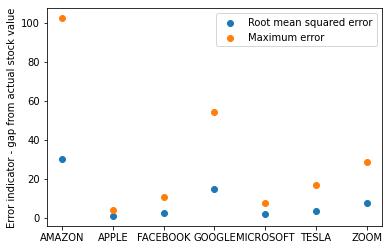

In [27]:
prep_csv_dict = cast_string_to_double(csv_dict)
pred_dict = perform_regression_dict(prep_csv_dict)  
rmse_dict, max_abse_dict = compute_rmse_dict(pred_dict)

plt.scatter(x=rmse_dict.keys(), y=rmse_dict.values(), label="Root mean squared error")
plt.scatter(x=max_abse_dict.keys(), y=max_abse_dict.values(), label="Maximum error")
plt.ylabel("Error indicator - gap from actual stock value")
plt.legend()